In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False

import matplotlib.pyplot as plt

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Modeling

In [2]:
class FC_Block(nn.Module) : 
    def __init__(self, input_dim, output_dim) : 
        super(FC_Block, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.linear = nn.Linear(input_dim, output_dim)
        self.relu = nn.ReLU(inplace = True)
        self.bn = nn.BatchNorm1d(output_dim)
        self.dr = nn.Dropout(.1)

    def forward(self, x) : 
        out = self.linear(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dr(out)
        return out

In [38]:
class AutoEncoder(nn.Module) : 

    def __init__(self , denoise = False) : 
        super(AutoEncoder,self).__init__()
        self.denoise = denoise
        self.linear1 = FC_Block(28*28, 256)
        self.linear2 = FC_Block(256, 32)
        self.linear3 = FC_Block(32, 256)
        self.decoder = nn.Linear(256, 28*28)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input) : 
        batch_size = input.size(0)
        input = input.view(-1,28*28)
        if self.denoise : 
            input += np.random.normal(0, 0.05, 28*28)
        x = self.linear1(input)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.decoder(x)
        x = self.sigmoid(x)

        return x.view(batch_size, 1, 28, 28)

In [39]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
AE = AutoEncoder(denoise = False).to(device)

# Load Data

In [40]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [48000, 12000])

In [41]:
dataloaders = {}
batch_size = 480
dataloaders['train'] = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
dataloaders['val'] = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
dataloaders['test'] = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

# Training

In [42]:
def saveModel(model, path): 
    torch.save(model.state_dict(), path) 

In [45]:
def train_AE(model, dataloader, num_epoch, optimizer, loss_fn) :
  from tqdm import tqdm
  train_loss_history = []
  valid_loss_history = []
  best_val_loss = 1e+7
  early_stop = 0

  for epoch in range(num_epoch) : 
    for phase in ['train','val'] : 
      if phase == 'train' : 
        model.train()
      else : 
        model.eval()
      running_loss = 0

      for x,_ in dataloader[phase] :
        optimizer.zero_grad()
        x = x.to(device)
        with torch.set_grad_enabled(phase == 'train') :
          output = model(x)
          loss = loss_fn(output, x)

          if phase == 'train' : 
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * x.size(0)
      epoch_loss = running_loss / len(dataloader[phase])

      if phase == 'train' : 
        train_loss_history.append(epoch_loss)
      else : 
        valid_loss_history.append(epoch_loss)
      
      if phase == 'val' and epoch_loss < best_val_loss : 
        print('')
        print(f'Best Model Saved at Epoch : {epoch} with loss {epoch_loss}')
        best_val_loss = epoch_loss
        saveModel(model, 'AE.pth')
        early_stop = 0
      elif phase == 'val' : 
        early_stop += 1
      
      if early_stop >= 5 : 
        break;
  model.load_state_dict(torch.load('AE.pth'))
  return model

In [46]:
AE_optimizer = optim.Adam(AE.parameters(), lr = 0.002)
AE_loss_fn = nn.MSELoss().to(device)
AE = train_AE(AE, dataloaders, 5, AE_optimizer, AE_loss_fn)


Best Model Saved at Epoch : 0 with loss 5.284387099742889

Best Model Saved at Epoch : 1 with loss 5.261003029346466

Best Model Saved at Epoch : 2 with loss 5.186221271753311

Best Model Saved at Epoch : 4 with loss 5.185020053386689


# Reconstruct Test

In [47]:
for x, _ in dataloaders['test'] : 
  break;

In [51]:
test_images = x[:10].to(device)

In [52]:
new_image = AE(test_images).detach().cpu().numpy()

In [54]:
new_image.shape

(10, 1, 28, 28)

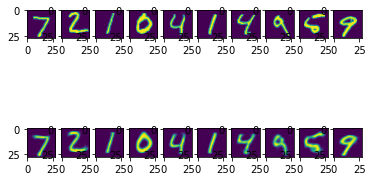

In [55]:
import matplotlib.pyplot as plt
import matplotlib

for i in range(1,11) : 
  plt.subplot(2,10,i)
  plt.imshow(x[i-1][0].numpy())
  plt.subplot(2,10, i+ 10)
  plt.imshow(new_image[i-1][0])